# Imports

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import pmdarima as pm
from torchmetrics.regression import MeanAbsolutePercentageError
import warnings
warnings.filterwarnings("ignore")
import matplotlib
import random
from tqdm import tqdm

pd.set_option('display.max_columns', None)
plt.style.use('fivethirtyeight')

SMALL_SIZE = 8
matplotlib.rc('font', size=SMALL_SIZE)

random.seed = 21
torch.seed = 21
np.seed = 21

In [20]:
signals = pd.read_csv('../dataset/gtrends_normalized.csv')

def get_gtrends(df,values,max_len):
    sg = []
    for j in range(len(signals.index)):
        t = 0.0
        cat = values[0]
        col = values[1]
        app = values[2]
        if cat in signals.columns:
            t+=signals[cat].iloc[j]
        if col in signals.columns:
            t+=signals[col].iloc[j]
        if cat in signals.columns:
            t+=signals[cat].iloc[j]
        sg.append(t)
    return sg[:max_len]

In [2]:
class Loss_Evaluation():
    def __init__(self,training=True,device='cuda:0'):
        self.device = device
        if training:
            self.type = 'Train'
        else:
            self.type = 'Test'
        self.MAPE = MeanAbsolutePercentageError().to('cuda:0')
        self.MSE = nn.MSELoss()
        self.MAE = nn.L1Loss()
        
        self.mape_losses = []
        self.mae_losses = []
        self.mse_losses = []
        
    def calculate_loss(self,y_hat,y,show=False):
        y = torch.tensor(y)
        y_hat = torch.tensor(y_hat)
        mse = self.MSE(y_hat,y).item()
        mae = self.MAE(y_hat,y).item()
        mape = self.MAPE(y_hat,y).item()
        
        self.mse_losses.append(mse)
        self.mae_losses.append(mae)
        self.mape_losses.append(mape)
        
        if show:
            print(f'\n') 
            print(f'{self.type} MSE loss: {round(mse,4)}')
            print(f'{self.type} MAE loss: {round(mae,4)}')
            print(f'{self.type} MAPE loss: {round(mape,4)}')
        return (mse,mae,mape)
        
    def print_matrics(self):
        print(f'Average {self.type} MSE loss: {round(sum(self.mse_losses)/len(self.mse_losses),7)}')
        print(f'Average {self.type} MAE loss: {round(sum(self.mae_losses)/len(self.mae_losses),4)}')
        print(f'Average {self.type} MAPE loss: {round(sum(self.mape_losses)/len(self.mape_losses),4)}') 
    
    def get_losses(self):
        return {
            'mse': self.mse_losses,
            'mae': self.mae_losses,
            'mape': self.mape_losses,
            'type': self.type
        }

## On Test Set

In [8]:
data = pd.read_csv("../dataset/test_df.csv")
data.drop(columns=data.columns[:2],inplace=True)

In [17]:
data.head()

,article_id,product_type_name,graphical_appearance_name,colour_group_name,section_name,detail_desc,start_date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,days,weeks,months,years
0,214844001,Hair clip,Solid,Black,Womens Small accessories,Metal hair grips. Length 5 cm.,2018-09-20,0.010245,0.016831,0.013538,0.014270,0.008050,0.012075,0.005123,0.006220,0.006220,0.009513,0.006952,0.011343,0.010977,0.012441,0.010245,0.009513,0.008050,0.005488,0.008782,0.009147,0.008416,0.010977,0.018661,0.014270,0.009513,0.010611,0.012441,0.008782,0.009879,0.012075,0.010977,0.017197,0.015368,0.015368,0.009147,0.014636,0.019027,0.023417,0.024515,0.031467,0.021222,0.019759,0.010977,0.009513,0.016100,0.010245,0.010611,0.013172,0.004757,0.007684,0.005488,0.008050,0.006220,0.007684,0.005123,0.008050,0.005854,0.007318,0.005854,0.004391,0.002927,0.004025,0.006952,0.007318,0.014636,0.016465,0.010977,0.008050,0.004391,0.006220,0.009147,0.010611,0.006952,0.009513,0.014636,0.007318,0.008416,0.004025,0.000366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000366,0.006220,0.013172,0.020490,0.023052,0.017563,0.020124,0.020490,0.023783,0.018295,0.017563,0.022686,0.016100,0.017197,0.012075,0.015002,0.010977,0.013172,0.008416,0.008782,0.007318,0.5,0.6,0.75,0.0
1,375248009,Leggings/Tights,Solid,White,Girls Underwear & Basics,"3/4-length leggings in soft, organic cotton je...",2018-09-20,0.000732,0.001829,0.000000,0.000000,0.000000,0.000732,0.000366,0.000000,0.000000,0.000000,0.000000,0.000366,0.000000,0.000000,0.001098,0.000366,0.000366,0.000000,0.000732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000732,0.000000,0.001464,0.001098,0.001464,0.000366,0.000000,0.000366,0.001464,0.002561,0.002195,0.000366,0.001829,0.001464,0.001464,0.001464,0.000732,0.000732,0.001098,0.000366,0.000366,0.000000,0.000366,0.000000,0.000000,0.000000,0.000000,0.000000,0.002195,0.000732,0.000366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001098,0.001098,0.000732,0.001098,0.000732,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000366,0.000366,0.001829,0.000732,0.001829,0.001098,0.001464,0.000366,0.001464,0.000000,0.000366,0.001098,0.001829,0.000000,0.001098,0.000366,0.000000,0.000000,0.000000,0.000366,0.000000,0.000000,0.000000,0.000000,0.000732,0.5,0.6,0.75,0.0
2,398089010,Shorts,Denim,Blue,Ladies Denim,"Shorts in washed denim with a regular waist, s...",2018-09-20,0.001464,0.001829,0.000366,0.002195,0.001098,0.001098,0.007318,0.000732,0.000732,0.002561,0.002927,0.002561,0.002195,0.000732,0.005854,0.008050,0.012075,0.010611,0.014270,0.021954,0.011709,0.011709,0.007684,0.008416,0.007318,0.005854,0.005123,0.007318,0.002927,0.002195,0.005488,0.005123,0.001464,0.000732,0.002195,0.002195,0.000732,0.000366,0.000000,0.001098,0.000366,0.001464,0.000366,0.001098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000366,0.000000,0.000000,0.000000,0.000366,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.6,0.75,0.0
3,337777004,Shirt,Solid,Black,Young Boy,Long-sleeved shirt in woven fabric with a turn...,2018-09-20,0.004757,0.006952,0.003293,0.004025,0.008782,0.008782,0.005488,0.007684,0.011709,0.012441,0.021588,0.014636,0.006952,0.001098,0.000732,0.004025,0.002927,0.003293,0.003659,0.002927,0.002927,0.004025,0.005488,0.000732,0.000000,0.000366,

In [149]:
idx=1
train_len = 84
le = Loss_Evaluation()

start_date = pd.to_datetime(data['start_date'].iloc[idx])
dates = [start_date + pd.DateOffset(weeks=i) for i in range(105)]

name = [data.iloc[idx,1],data.iloc[idx,3],data.iloc[idx,2]]
sales = data.iloc[idx,7:-4].tolist()

df = pd.DataFrame({'weeks':dates,'sales':sales})
df.index = pd.to_datetime(df['weeks'])
df.drop(columns='weeks',inplace=True)
df = df.replace(0.0,0.00001)
df['gtrends'] = get_gtrends(df,name,len(df.index))

train = df.iloc[:train_len,:]
test = df.iloc[train_len:,:]

In [158]:
arima = pm.auto_arima(train['sales'],X=train.drop(columns=['sales']), d=1,error_action='ignore', trace=True,
                  suppress_warnings=True, maxiter=100,m=4,stationary=False,test='adf')

pred = arima.predict(n_periods=105-train_len, X=test.drop(columns=['sales']), alpha=0.05)

for i in range(len(pred)):
    if pred[i] < 0:
        pred[i] = 0.0

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[4] intercept   : AIC=-983.855, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-975.112, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-982.016, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-986.465, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-977.109, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-988.520, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=-986.244, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=-984.471, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=-989.378, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=-987.317, Time=0.08 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=-987.237, Time=0.08 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=-985.211, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-984.217, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=-969.109, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept

In [159]:
le.calculate_loss(pred.tolist(), df['sales'].tolist()[train_len:],show=True)



Train MSE loss: 0.0
Train MAE loss: 0.0006
Train MAPE loss: 27.2262


(3.918856634754775e-07, 0.0005682395421899855, 27.226242065429688)

In [160]:
prediction = []
for i in range(len(train.index)):
    prediction.append(None)
for i in range(len(pred)):
    prediction.append(pred[i])

[]

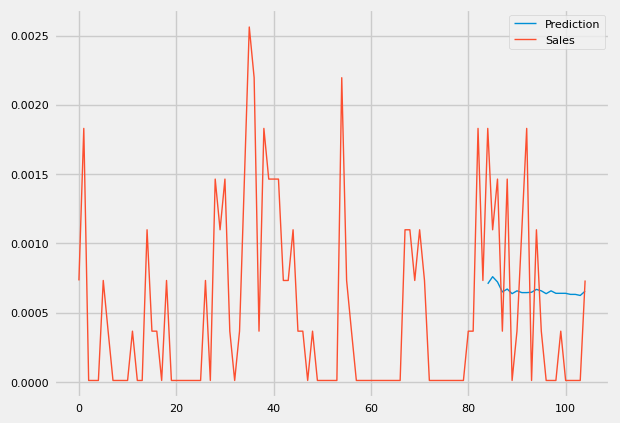

In [161]:
plt.plot(prediction,label='Prediction',linewidth =1)
plt.plot(df['sales'].to_list(),label='Sales',linewidth =1)
plt.legend()
plt.plot()

In [206]:
train_len = 84
predictions = []
all_sales = []
names = []

start_date = pd.to_datetime(data['start_date'].iloc[idx])
dates = [start_date + pd.DateOffset(weeks=i) for i in range(105)]
le = Loss_Evaluation()

for idx in tqdm(range(1), colour="#2E8B57"):
    name = f'{data.iloc[idx,3]} {data.iloc[idx,2]} {data.iloc[idx,1]}'
    names.append(name)
    
    sales = data.iloc[idx,7:-4].tolist()
    df = pd.DataFrame({'weeks':dates,'sales':sales})
    df.index = pd.to_datetime(df['weeks'])
    df.drop(columns='weeks',inplace=True)
    df = df.replace(0.0,0.00001)

    arima = pm.auto_arima(train['meantemp'],X=train.drop(columns=['date','meantemp']), d=2,error_action='ignore', trace=True,
                      suppress_warnings=True, maxiter=500,m=4,stationary=False,test='adf',start=train_len,end=104,dynamic=True)

    df['sarimax_forecast']= arima.predict(n_periods=100, X=test.drop(columns=['date','meantemp']), alpha=0.05)
    for i in range(len(df['sarimax_forecast'])):
        if df['sarimax_forecast'].iloc[i] < 0:
            df['sarimax_forecast'].iloc[i] = 0.0
    
    le.calculate_loss(df['sarimax_forecast'].tolist()[train_len:], df['sales'].tolist()[train_len:])
    
    all_sales.append(df['sales'].tolist())
    predictions.append(df['sarimax_forecast'].tolist())#[-34:])

le.print_matrics()

100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [20:55<00:00, 19.92s/it]

Average Train MSE loss: 6.63e-05
Average Train MAE loss: 0.0034
Average Train MAPE loss: 76.6989


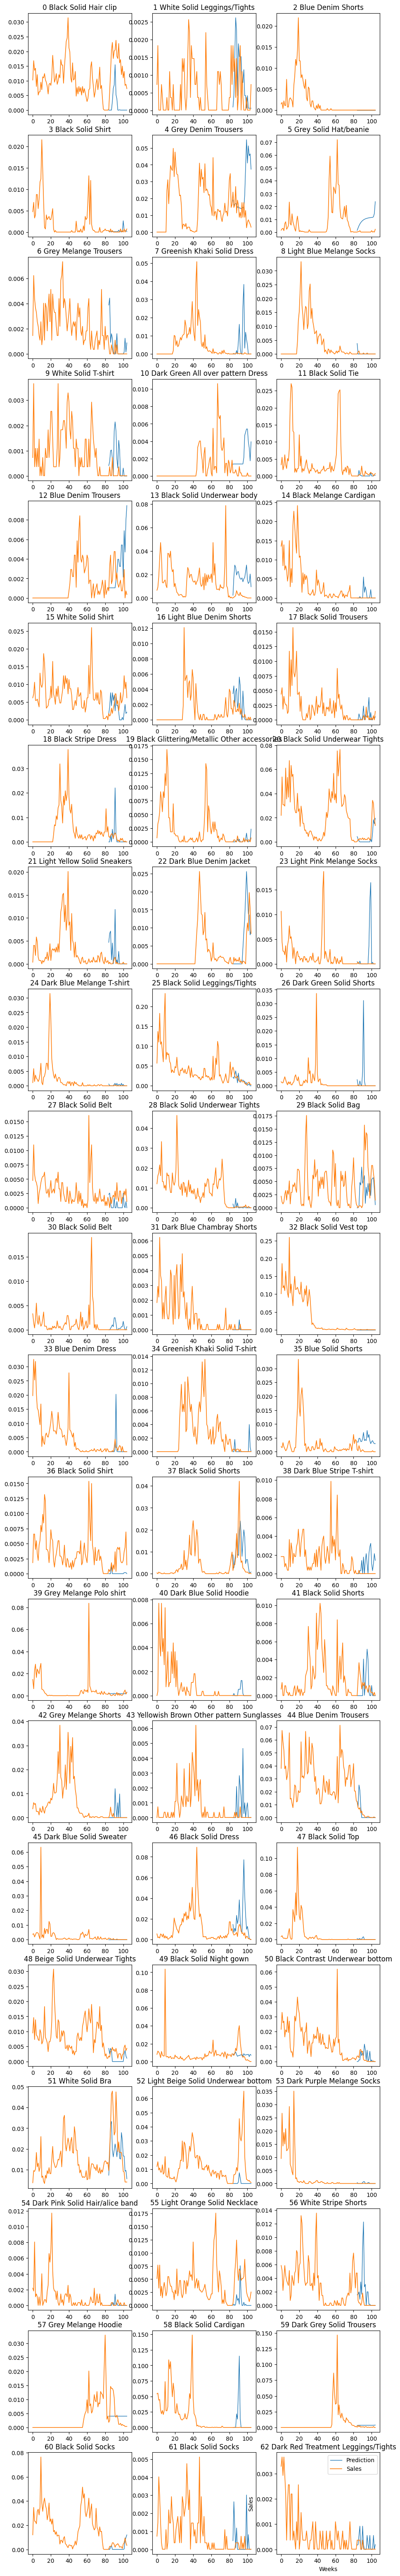

In [208]:
cols = 3
rows = 21
fig, ax = plt.subplots(ncols=cols,nrows=rows,figsize=(11,80))

idx=0
for i in range(rows):
    for j in range(cols):
        ax[i,j].plot(predictions[idx],label = "Prediction", linewidth=1)
        ax[i,j].plot(all_sales[idx],label = "Sales", linewidth=1.2)
        ax[i,j].title.set_text(f'{str(idx)} {names[idx]}')
        idx+=1

plt.xlabel('Weeks')
plt.ylabel('Sales')
plt.legend()
plt.show()